import all libraries and dependencies

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
import os
plt.style.use('ggplot')



Create table and getting engagement ratio

In [81]:
df = pd.read_csv('sentiment_data.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index(['date', 'symbol'], inplace=True)
df

df['engagement'] = df['twitterComments']/df['twitterLikes']
df = df[(df['twitterComments']>10)&(df['twitterLikes']>20)]
df

twitterPosts  twitterComments  twitterLikes  \
date       symbol                                                
2021-11-18 AAPL           811.0           2592.0       21674.0   
           AMD            150.0            675.0        2949.0   
           AMZN           557.0           1315.0       12969.0   
           ATVI            82.0             36.0         131.0   
           BA              61.0             55.0         342.0   
...                         ...              ...           ...   
2023-01-04 T              184.0           3409.0       14271.0   
           TSLA          6767.0         540711.0     3810688.0   
           TSN             35.0            168.0         460.0   
           V              132.0           1008.0        5943.0   
           XOM            212.0            374.0        2071.0   

                   twitterImpressions  twitterSentiment  engagement  
date       symbol                                                    
2021-11-18 AAPL             7981808.0               NaN    0.119590  
           AMD              1645270.0               NaN    0.228891  
           AMZN             5590695.0               NaN    0.101396  
           ATVI             1310715.0               NaN    0.274809  
           BA                425847.0               NaN    0.160819  
...                               ...               ...         ...  
2023-01-04 T                 884935.0          0.590457    0.238876  
           TSLA            55464921.0          0.543057    0.141893  
           TSN                57207.0          0.561900    0.365217  
           V                 139835.0          0.567286    0.169611  
           XOM               483389.0          0.588914    0.180589  

[25375 rows x 6 columns]

Aggregating table

In [32]:
aggregated_df = df.reset_index('symbol').groupby([pd.Grouper(freq='M'), 'symbol'])[['engagement']].mean()
aggregated_df['rank'] = aggregated_df.groupby(level=0)['engagement'].transform(lambda x: x.rank(ascending=False))

Filtering the table

In [52]:
filtered_df = aggregated_df[aggregated_df['rank'] < 6].copy()

filtered_df = filtered_df.reset_index(level=1)
filtered_df.index = filtered_df.index + pd.DateOffset(1)
filtered_df = filtered_df.reset_index().set_index(['date', 'symbol'])

filtered_df.head(20)


engagement  rank
date       symbol                  
2021-12-01 AES       0.864613   2.0
           FCX       0.626323   5.0
           MNST      0.699721   3.0
           OXY       2.147741   1.0
           SLB       0.647374   4.0
2022-01-01 D         0.801994   5.0
           FCX       0.841220   4.0
           L         6.507246   1.0
           LUV       1.303215   2.0
           MA        0.883401   3.0
2022-02-01 AMD       0.715556   4.0
           D         1.136678   1.0
           FCX       0.655237   5.0
           LUV       1.035258   2.0
           MA        0.729063   3.0
2022-03-01 FCX       1.138332   2.0
           GILD      0.530886   5.0
           LUV       1.574377   1.0
           MRO       0.581748   4.0
           OXY       1.025579   3.0

In [95]:
dates = filtered_df.index.get_level_values('date').unique().tolist()
fixed_dates = {}

for d in dates:
    fixed_dates[d.strftime("%Y-%m-%d")] = filtered_df.xs(d).index.tolist()

fixed_dates

{'2021-12-01': ['AES', 'FCX', 'MNST', 'OXY', 'SLB'],
 '2022-01-01': ['D', 'FCX', 'L', 'LUV', 'MA'],
 '2022-02-01': ['AMD', 'D', 'FCX', 'LUV', 'MA'],
 '2022-03-01': ['FCX', 'GILD', 'LUV', 'MRO', 'OXY'],
 '2022-04-01': ['A', 'CRM', 'PFE', 'PM', 'STZ'],
 '2022-05-01': ['AMD', 'CRM', 'CVX', 'J', 'KEY'],
 '2022-06-01': ['AMD', 'DD', 'FCX', 'KEY', 'LMT'],
 '2022-07-01': ['CB', 'CRM', 'DD', 'FCX', 'STZ'],
 '2022-08-01': ['A', 'DD', 'JPM', 'REGN', 'STZ'],
 '2022-09-01': ['ABT', 'DIS', 'L', 'META', 'MRNA'],
 '2022-10-01': ['J', 'KEY', 'L', 'META', 'MU'],
 '2022-11-01': ['A', 'DD', 'FCX', 'J', 'META'],
 '2022-12-01': ['AEP', 'AES', 'DD', 'J', 'STZ'],
 '2023-01-01': ['A', 'AES', 'DAL', 'J', 'KEY'],
 '2023-02-01': ['A', 'AES', 'BIIB', 'FCX', 'MDT']}

In [91]:
stocks_list = df.index.get_level_values('symbol').unique().tolist()

stocks_prices = yf.download(tickers=stocks_list, start='2021-12-01', end='2024-07-27')

[*********************100%%**********************]  85 of 85 completed

1 Failed download:
['ATVI']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


In [112]:
returns_df = np.log(stocks_prices['Adj Close']).diff()["2021-12-02":]


In [124]:
portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():

    end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd()).strftime("%Y-%m-%d")
    cols = fixed_dates[start_date]
    temp_df = returns_df[start_date:end_date][cols].mean(axis=1).to_frame('portfolio_return')
    portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)

portfolio_df

,portfolio_return
Date,
2021-12-02,0.024872
2021-12-03,-0.007711
2021-12-06,0.023925
2021-12-07,0.030547
2021-12-08,0.001167
...,...
2023-02-22,-0.007870
2023-02-23,-0.007323
2023-02-24,-0.009463


In [125]:
qqq_df = yf.download(tickers="QQQ",
                 start="2021-12-02", end='2023-02-28')

qqq_ret = np.log(qqq_df["Adj Close"]).diff().to_frame('nasdaq_return')
portfolio_df = portfolio_df.merge(qqq_ret, left_index=True, right_index=True)


[*********************100%%**********************]  1 of 1 completed


In [126]:
portfolio_df

,portfolio_return,nasdaq_return
Date,,
2021-12-02,0.024872,NaN
2021-12-03,-0.007711,-0.017542
2021-12-06,0.023925,0.007981
2021-12-07,0.030547,0.029669
2021-12-08,0.001167,0.004464
...,...,...
2023-02-21,-0.010442,-0.023960
2023-02-22,-0.007870,0.000748
2023-02-23,-0.007323,0.008696


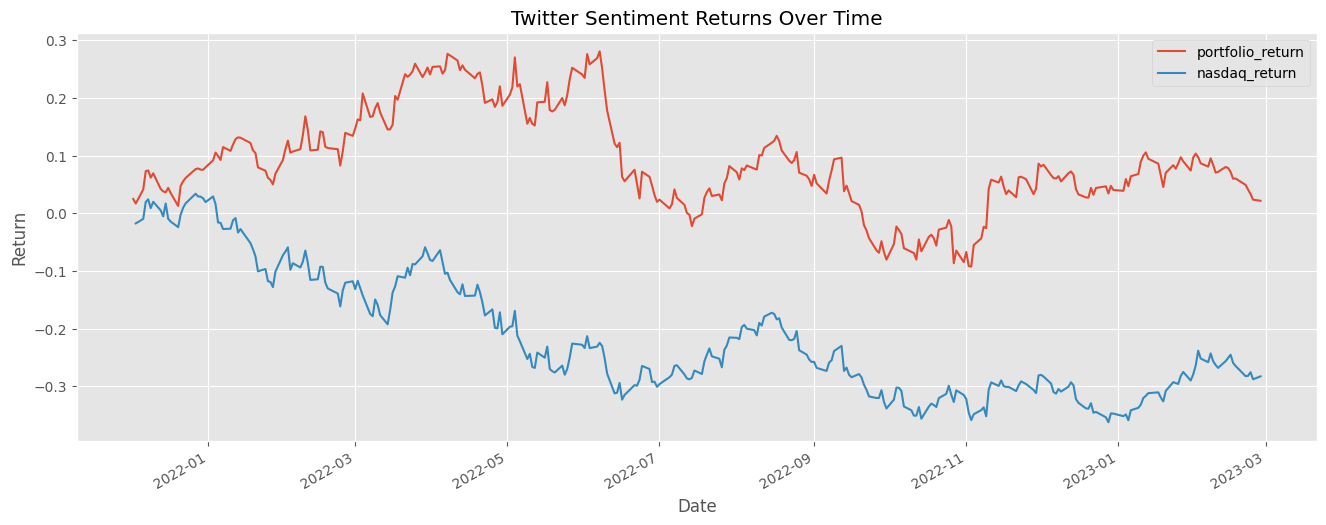

In [129]:
portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum()).sub(1)

portfolio_cumulative_return.plot(figsize=(16, 6))

plt.title("Twitter Sentiment Returns Over Time")
plt.ylabel('Return')

plt.show()
